In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer

import torch
import torch.nn as nn
import torch.nn.functional as F

import umap
import MulticoreTSNE

In [2]:
data = pd.read_csv('../data/SMSSpamCollection', sep='\t', header=None)
data['Text'] = data[1].str.replace('[^\w\s]','')
data.columns = ['label', 'Full Text', 'Text']
data['Lower Case Text'] = data['Text'].str.lower()

In [3]:
labels, counts = np.unique(data['label'], return_counts=True)
encoder = preprocessing.LabelEncoder()
encoder.fit(labels[np.argsort(-counts)])
data['y'] = encoder.transform(data['label'])

In [4]:
np.random.seed(42)
mask_train = np.random.random(data.shape[0]) < 0.8
data_train = data[mask_train]
data_test = data.iloc[~mask_train, :]

In [5]:
#up sample data train for word2vec vocabulary
countToIncrease_word = data_train[data_train['y'] == 0].shape[0] - data_train[data_train['y'] == 1].shape[0]
spamupsampled_word = data_train[data_train['y'] == 1].sample(n=countToIncrease_word, replace=True)
data_train_upsample_word2vec = pd.concat([spamupsampled_word, data_train])

In [6]:
count_vect_sing_word = CountVectorizer(stop_words=ENGLISH_STOP_WORDS)
count_vect_sing_word.fit(data_train_upsample_word2vec['Lower Case Text'])
tokenizer_word = count_vect_sing_word.build_tokenizer()

In [7]:
VOCAB_SIZE = len(count_vect_sing_word.vocabulary_)
EMBEDDING_SIZE = 300
word_to_ix = count_vect_sing_word.vocabulary_

In [8]:
class TwoGramLanguageModeler(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(TwoGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)
    
    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [9]:
CONTEXT_SIZE = 1
EMBEDDING_DIM = EMBEDDING_SIZE

In [10]:
word2vec_model = TwoGramLanguageModeler(VOCAB_SIZE, EMBEDDING_DIM, CONTEXT_SIZE)

In [11]:
MODEL_PATH = '../data/word_2vec_model'
word_embeddings = word2vec_model.embeddings
word2vec_model.load_state_dict(torch.load(MODEL_PATH))
word2vec_model.eval()

TwoGramLanguageModeler(
  (embeddings): Embedding(8111, 300)
  (linear1): Linear(in_features=300, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=8111, bias=True)
)

In [12]:
# count_vect_sing_word is a CountVectorizer
def _indicesForSentence(input_str, tokenizer = tokenizer_word, count_vect = count_vect_sing_word):
    input_str = list(filter(lambda x: x in count_vect.vocabulary_, tokenizer(input_str)))
    return torch.tensor([[word_to_ix[word]] for word in input_str], dtype=torch.long)

def sentenceToNumpyInstance(input_str, embedder):
    embeddings = embedder(_indicesForSentence(input_str))
    if embeddings.shape == torch.Size([0]):
        return np.zeros(EMBEDDING_SIZE)
    else:
        return torch.Tensor.numpy(embeddings.detach())
    
def word2vec_transform(data, embeddings, field = 'Lower Case Text'):
    return np.array(data[field].apply(sentenceToNumpyInstance, embedder=embeddings).values.tolist())

In [13]:
words = []
for item in count_vect_sing_word.vocabulary_.items():
    words.append(item[0])
words = np.array(words)

In [14]:
words[:50]

array(['money', 'lucky', 'winner', 'claim', 'prize', 'text', '88600',
       '1million', 'away', 'ppt150x3normal', 'rate', 'box403', 'w1t1jy',
       'ur', 'going', 'bahamas', 'callfreefone', '08081560665', 'speak',
       'live', 'operator', 'cruise', 'of2000', 'cash', '18only', 'opt',
       'txt', '07786200117', 'awarded', 'sipix', 'digital', 'camera',
       '09061221061', 'landline', 'delivery', '28days', 'cs', 'box177',
       'm221bp', '2yr', 'warranty', '150ppm', '16', 'p399', 'colours',
       'euro', '2004', '241', 'offer', 'england'], dtype='<U48')

In [15]:
embeddings_vocab = []
for w in words:
    embeddings_vocab.append(sentenceToNumpyInstance(w, embedder = word_embeddings))

In [16]:
embeddings_vocab_tmp = []
for e in embeddings_vocab:
    embeddings_vocab_tmp.append(e[0][0])
embeddings_vocab = np.array(embeddings_vocab_tmp)

In [17]:
embeddings_vocab.shape

(8111, 300)

In [18]:
embeddings_vocab[0]

array([ 0.44552433, -1.5492862 ,  0.47135913,  1.5637647 , -0.10818722,
       -1.6535847 ,  0.07165031,  0.16836956,  0.37172526,  1.3400873 ,
        0.8337308 , -0.07802942,  0.8745154 ,  1.653082  , -1.8206191 ,
       -0.97816443, -0.18698388, -2.132623  ,  0.37131318, -0.10772566,
        0.32323444,  0.06486494, -0.04877785, -0.25652158, -0.42022857,
        0.7917371 , -0.09540772, -1.5739617 ,  1.0771434 , -0.08722471,
        0.7635218 ,  1.6410326 , -1.2550762 ,  1.5224941 , -1.1775321 ,
        0.39126888, -0.10000006,  0.72705024,  0.47781116, -0.7533402 ,
        0.22656332,  0.68221235, -0.6108465 , -1.3587086 , -0.4296701 ,
        0.28894004, -1.3430033 ,  0.7534728 ,  0.9140964 ,  0.7349015 ,
        0.43407756, -0.13346036,  0.5857832 ,  2.6698682 ,  1.9138197 ,
        0.4619449 ,  1.1265758 , -0.8649725 ,  0.00571695,  0.20795172,
        0.2477195 ,  0.7745893 , -1.7390242 , -2.0409973 ,  0.82292855,
        1.0035732 ,  1.76408   , -1.0699602 ,  0.2926401 , -0.86

In [19]:
embs = embeddings_vocab

reducer = umap.UMAP()

transformed_embs = reducer.fit_transform(embs)

In [20]:
transformed_embs[:10], words[:10]

(array([[ 2.3301227 ,  1.2324159 ],
        [-0.06123981, -2.7946227 ],
        [ 1.4403331 ,  1.328368  ],
        [ 0.65484643, -0.27962136],
        [ 2.2350643 ,  1.4637889 ],
        [ 2.095908  , -1.0125872 ],
        [ 2.895883  , -0.86320573],
        [ 0.31839868,  1.1136062 ],
        [ 1.3275672 , -2.499765  ],
        [ 1.1867987 ,  1.114739  ]], dtype=float32),
 array(['money', 'lucky', 'winner', 'claim', 'prize', 'text', '88600',
        '1million', 'away', 'ppt150x3normal'], dtype='<U48'))

(8111, 2)


Text(0.5,1,'Word Embeddings in 2D')

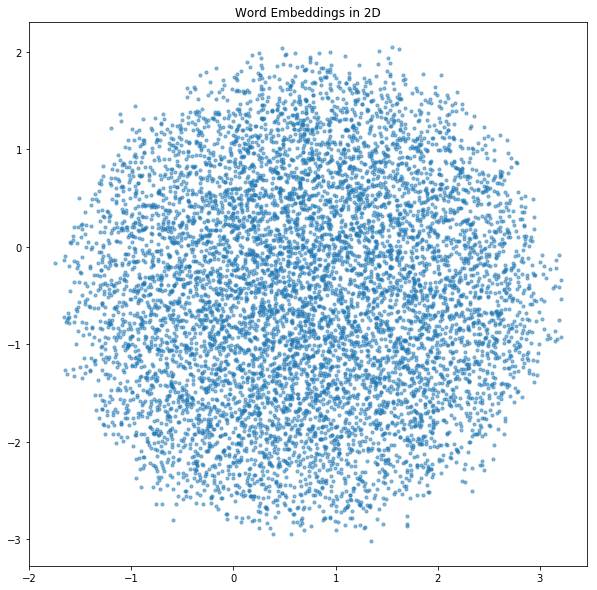

In [21]:
print(transformed_embs.shape)
plt.figure(figsize = (10,10))
plt.scatter(transformed_embs[:,0], transformed_embs[:,1], 
            cmap="Spectral", s=10, alpha=0.5)
plt.title('Word Embeddings in 2D')

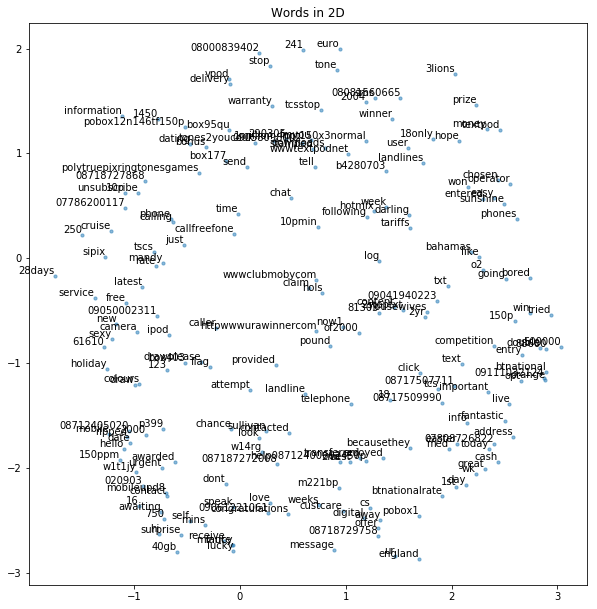

In [22]:
subset_embs = transformed_embs[:200]
plt.figure(figsize = (10,10))
plt.subplots_adjust(bottom = 0.1)
plt.scatter(subset_embs[:,0], subset_embs[:,1], 
            marker='o', cmap='Spectral', s=10, alpha=0.5)
plt.title('Words in 2D')

for label, x, y in zip(words, subset_embs[:, 0], subset_embs[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(0, 0),
        textcoords='offset points', ha='right', va='bottom')

In [23]:
words_string = ' '.join(words)

In [24]:
import spacy

#use larger model
nlp = spacy.load('en_core_web_md')  
tokens = nlp(words_string[:1000])

t1_text = []
t2_text = []
sim = []
for token1 in tokens:
    for token2 in tokens:
        t1_text.append(token1.text), t2_text.append(token2.text), sim.append(token1.similarity(token2))

In [25]:
df_sim = pd.DataFrame({'t1':t1_text, 't2':t2_text, 'similarity':sim}) 
df_sim = df_sim[df_sim['t1'] != df_sim['t2']]
wordsim = df_sim.sort_values('similarity', ascending=False)[:30]

In [26]:
wordsim

,t1,t2,similarity
17841,wk,2yr,1.000000
5511,2yr,wk,1.000000
16326,18,16,0.947691
5914,16,18,0.947691
3174,cash,money,0.819067
23,money,cash,0.819067
17222,win,won,0.818671
15304,won,win,0.818671
2044,going,just,0.818308
15470,just,going,0.818308


In [27]:
top_sim_words = wordsim['t1'] #text1 from top 30 sim matches from sample
top_sim_words = list(set(top_sim_words)) #removing duplicates
words = list(words)
wrd = [i for i in top_sim_words]

idx_val = []
for wrd in range(len(top_sim_words)):
    try:
        idx_val.append(words.index(top_sim_words[wrd]))
    except ValueError:
        continue

In [28]:
idx_val = sorted(idx_val)
sim_emb = transformed_embs[idx_val]
words = np.array(words)
sim_words = words[idx_val]

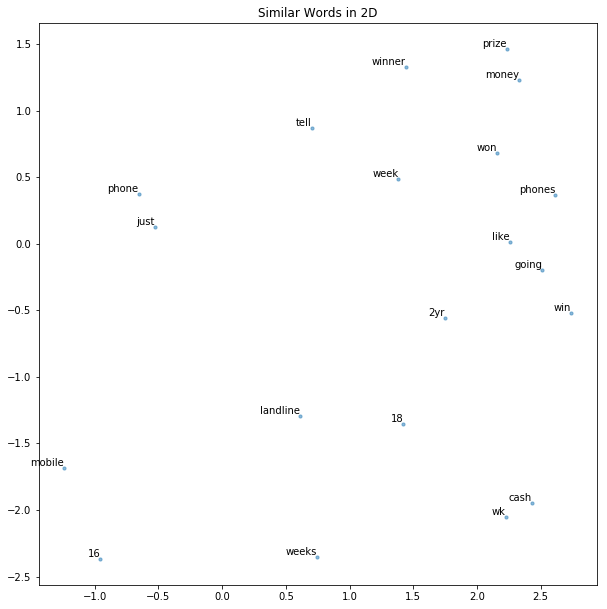

In [29]:
plt.figure(figsize = (10,10))
plt.subplots_adjust(bottom = 0.1)
plt.scatter(sim_emb[:,0], sim_emb[:,1], 
            marker='o', cmap='Spectral', s=10, alpha=0.5)
plt.title('Similar Words in 2D')

for label, x, y in zip(sim_words, sim_emb[:, 0], sim_emb[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(0, 0),
        textcoords='offset points', ha='right', va='bottom')